## Intro
#### In this karnel I'll be working on the Email Spam Detection Dataset to build 4 classification models and choose the best classifier between them, then I'll train an unsupervised anomaly detection called (Outlier detection with Local Outlier Factor) to check its accuracy and to be my very first use of anomaly detection algorithms (although I know that it's not a case that they should be used in)

In [1]:
# importing libraries.

import numpy as np 
import pandas as pd 
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
sns.set(font_scale = 1.5)
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import LocalOutlierFactor

In [2]:
# reading the data and showing a sample of it.
d = pd.read_csv('../input/email-spam-detection-dataset-classification/spam.csv',encoding = "ISO-8859-1")
d.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
# filtering the data.
d = d.iloc[:,:2].rename(columns = {'v1':'label', 'v2':'text'})
d.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# showing brief information about the dataset.
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
# Showing some describtive statistics about the data.
d.describe()

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


### How many spam emails are there?

In [6]:
px.pie(d,'label')

### What is the distribution of length for each email type?

In [7]:
d['length'] = d.text.apply(len)
for u in d['label'].unique():
    print(f'Average {u} length = {round(d[d.label==u].length.mean(),2)}')
    print(f'Most frequent {u} length = {round(d[d.label==u].length.mode()[0],2)}')
px.histogram(d,x='length', color = 'label')

Average ham length = 71.02
Most frequent ham length = 22
Average spam length = 138.87
Most frequent spam length = 159


### Preprocessing:

In [8]:
d.label = LabelEncoder().fit_transform(d.label)
d.head()

,label,text,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [9]:
X_train, X_valid, y_train, y_valid= train_test_split(d['text'], d['label'], test_size=0.2, random_state=0)
X_train.head()

1114    No no:)this is kallis home ground.amla home to...
3589    I am in escape theatre now. . Going to watch K...
3095    We walked from my moms. Right on stagwood pass...
1012       I dunno they close oredi not... ÌÏ v ma fan...
3320                               Yo im right by yo work
Name: text, dtype: object

In [10]:
tfv = TfidfVectorizer(stop_words='english')

tfv_train = tfv.fit_transform(X_train)
tfv_valid= tfv.transform(X_valid)

tfv_train.shape

(4457, 7351)

In [11]:
def best_estimator(estimator, params, X_train = tfv_train, y_train_ = y_train, scorer = None):
    
    grid = GridSearchCV(estimator, params, scoring= scorer)
    grid.fit(X_train, y_train_)

    bestEstimator = grid.best_estimator_
    print(f'Best estimator: {bestEstimator}')
    
    CVscore = cross_val_score(bestEstimator, X_train, y_train_, cv=5, scoring= scorer)
    print('Cross Validation Score: ', round(CVscore.mean() * 100, 2).astype(str) + '%')
    
    return bestEstimator

def cf(model, X_valid = tfv_valid, y_valid_ = y_valid):
    
    y_pred = model.predict(X_valid)
    confusionMatrix = confusion_matrix(y_valid_, y_pred)

    sns.heatmap(confusionMatrix, annot=True, fmt='g', cbar=False, cmap='PiYG')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.show()

### Logistic Regression 

In [12]:
log_reg_params = {"penalty": ['l1', 'l2'],
                  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

log_reg = best_estimator(LogisticRegression(), log_reg_params)

Best estimator: LogisticRegression(C=1000)
Cross Validation Score:  97.89%


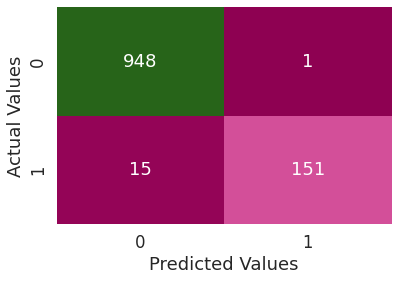

In [13]:
cf(log_reg)

### KNN

In [14]:
knears_params = {"n_neighbors": list(range(1,100,2))}

knears_neighbors = best_estimator(KNeighborsClassifier(), knears_params)

Best estimator: KNeighborsClassifier(n_neighbors=1)
Cross Validation Score:  94.17%


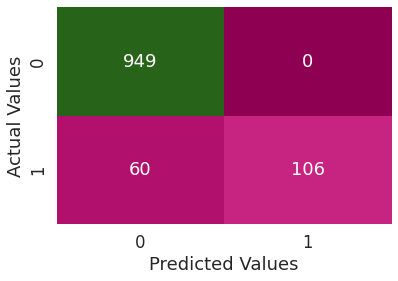

In [15]:
cf(knears_neighbors)

##### From my perspective, I believe that the KNN model is doing better than the LR model regarding our problem here, though its cross validation is lower and false nigatives are higher, as I'd give the higher priority to ham emails not being classified as spam emails and not the opposite.

### Random Forest

In [16]:
# random_params = {'n_estimators': [100, 200, 500],
#                  'min_samples_split': [2, 5],
#                  'bootstrap': [True, False]}

# RF = best_estimator(RandomForestClassifier(), random_params)

RF = RandomForestClassifier(n_estimators=500, min_samples_split = 5, bootstrap = False).fit(tfv_train, y_train) # this was the beast estimator.
CVscore = cross_val_score(RF, tfv_train, y_train, cv=5)
print('Cross Validation Score: ', round(CVscore.mean() * 100, 2).astype(str) + '%')

Cross Validation Score:  97.91%


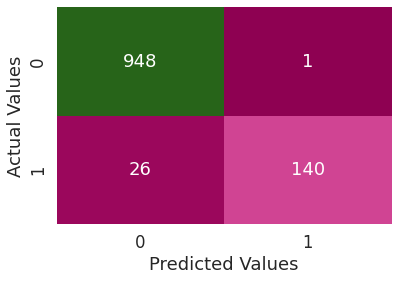

In [17]:
cf(RF)

### XGB

In [18]:
# xgbparams = {'n_estimators': [100, 500, 1000],
#     'learning_rate': [0.01,0.05,0.1],
#     'booster': ['gbtree', 'gblinear'],
#     'reg_alpha': [0, 0.5, 1],
#     'reg_lambda': [0.5, 1]}

# xgb = best_estimator(XGBClassifier(n_jobs=-1), xgbparams)

xgb = XGBClassifier(n_jobs=-1,n_estimators=1000,learning_rate=0.1,booster='gbtree',reg_alpha=0.5, reg_lambda=1).fit(tfv_train, y_train)
CVscore = cross_val_score(xgb, tfv_train, y_train, cv=5)
print('Cross Validation Score: ', round(CVscore.mean() * 100, 2).astype(str) + '%')

Cross Validation Score:  97.53%


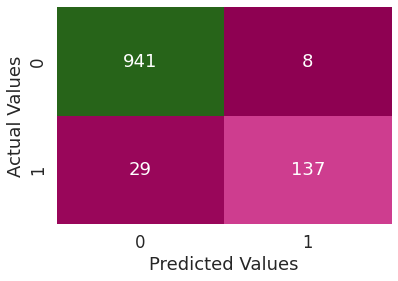

In [19]:
cf(xgb)

## ALL DONE! 
for classification
### LocalOutlierFactor Testing

In [20]:
d['label'][d.label == 1] = -1
d['label'][d.label == 0] = 1
text = tfv.fit_transform(d['text'])

LOF = LocalOutlierFactor(n_neighbors=23, contamination=0.1)
LOFpred = LOF.fit_predict(text)

n_true_preds = (LOFpred==d['label'].values).sum()
n_true_preds

4521

In [21]:
accuracy = n_true_preds/len(d['label'].values)
accuracy

0.8113783201722901

In [22]:
LOFpred_series = pd.Series(LOFpred)
LOFpred_series[LOFpred_series == 1] = 0
LOFpred_series[LOFpred_series == -1] = 1

d['label'][d.label == 1] = 0
d['label'][d.label == -1] = 1

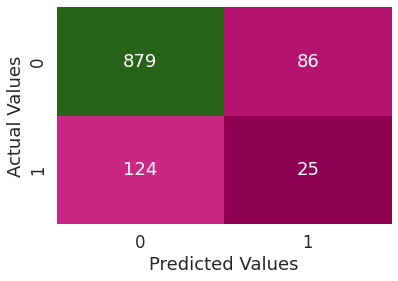

In [23]:
confusionMatrix = ((confusion_matrix(d['label'], LOFpred_series))*0.2).round()

sns.heatmap(confusionMatrix, annot=True, fmt='g', cbar=False, cmap='PiYG')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

##### The LocalOutlierFactor detector classified 4521 (81%) emails right by just the text of the email (without any learning from the target unlike the classifiers).